# Photonic crystal waveguide polarization filter

Run this notebook in your browser using [Binder](https://mybinder.org/v2/gh/flexcompute-readthedocs/tidy3d-docs/readthedocs?labpath=docs%2Fsource%2Fnotebooks%2FPhotonicCrystalWaveguidePolarizationFilter.ipynb).

Polarization control is one of the central themes in integrated silicon photonics. Different polarization modes not only allow for more information-carrying channels but also enable a wide range of applications given their different characteristics. For example, waveguide TE modes usually have better confinement and thus they are less prone to sidewall roughness. TM modes, on the other hand, have a larger penetration depth into the top and bottom claddings, which makes them suitable for sensing applications. As a result, integrated silicon photonic filters that selectively transmit or block certain polarization are very useful. 

This notebook demonstrates the modeling of a compact TM-pass polarization filter based on photonic crystal waveguide. The photonic crystal is an air-bridged silicon slab with periodic air holes arranged in a triangular lattice. It is possible to achieve a TM-pass but TE-block device within a frequency range by utilizing bandgap engineering and index guiding mechanism. The design parameters adopted from [Chandra Prakash and Mrinal Sen , "Optimization of silicon-photonic crystal (PhC) waveguide for a compact and high extinction ratio TM-pass polarization filter", Journal of Applied Physics 127, 023101 (2020)](https://aip.scitation.org/doi/abs/10.1063/1.5130160) are optimized for the telecom frequency to have a ~-0.5 dB TM transmission and ~-40 dB TE transmission. 

<img src="img/phc_polarization_filter.png" width="500">

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins import ModeSolver

[08:50:31] INFO     Using client version: 1.8.2                                                     ]8;id=684474;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\__init__.py\__init__.py]8;;\:]8;id=809272;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\__init__.py#120\120]8;;\

## Simulation Setup 

This device is designed to work in a wide frequency range from 1480 nm to 1620 nm.

In [2]:
lda0 = 1.55  # central wavelength
freq0 = td.C_0 / lda0  # central frequency
ldas = np.linspace(1.48, 1.62, 100)  # wavelength range of interest
freqs = td.C_0 / ldas  # frequency range of interest

Since the photonic crystal slab is air-bridged, we only need to define two materials: silicon and air. The frequency dispersion of the silicon refractive index in the frequency range of interest is quite small. Therefore, in this notebook, we model it as non-dispersive and lossless. 

In [3]:
n_si = 3.47  # silicon refractive index
si = td.Medium(permittivity=n_si**2)

n_air = 1  # air refractive index
air = td.Medium(permittivity=n_air)

For the photonic crystal to work as a filter, the geometric parameters need to be carefully chosen such that bandgap lies within the frequency range of interest. The design process would require the calculation of band structures. In this notebook, we will skip the band structure calculation and only model the optimized device. For band diagram simulation, refer to the [photonic crystal slab band structure calculation notebook](https://docs.flexcompute.com/projects/tidy3d/en/latest/notebooks/Bandstructure.html).

Define the geometric parameters for the photonic crystal as well as the input and output straight waveguides.

In [4]:
a = 0.42  # lattice constant
t = 0.75 * a  # slab thickness
r = 0.3 * a  # radius of air holes
w = 0.73 * a  # width of the photonic crystal waveguide section

N_holes = 11  # number of holes in each row
N_rows = 7  # number of rows of holes on each side of the waveguide
L = N_holes * a  # length of the photonic crystal waveguide

D = 0.4  # width of the input and output waveguides

inf_eff = 1e3  # effective infinity of the model

To build the device, we define the silicon slab, input and output straight waveguides, and air holes. The air holes are systematically defined using a nested for loop. Due to the mirror symmetry of the device with respect to the $xz$ plane, We only define the air holes in $y>0$. Later, we will define the symmetry condition in the simulation.

In [5]:
# define the silicon slab
si_slab = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-L / 2, -N_rows * np.sqrt(3) * a / 2 - w / 2, 0),
        rmax=(L / 2, N_rows * np.sqrt(3) * a / 2 + w / 2, t),
    ),
    medium=si,
)

# define the input and output straight waveguides
si_wg = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-inf_eff, -D / 2, 0),
        rmax=(inf_eff, D / 2, t),
    ),
    medium=si,
)

# systematically define air holes
holes = []
for i in range(N_rows):
    if i % 2 == 0:
        shift = a / 2
        N = N_holes
    else:
        shift = 0
        N = N_holes + 1
        
    for j in range(N):
        holes.append(
            td.Structure(
                geometry=td.Cylinder(
                    center=(
                        (j - (N_holes) / 2) * a + shift,
                        (w / 2 + r) + (i) * np.sqrt(3) * a / 2,
                        t / 2,
                    ),
                    radius=r,
                    length=t,
                ),
                medium=air,
            )
        )

A [ModeSouce](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.ModeSource.html?highlight=modesource) is defined at the input waveguide to launch either the fundamental TE or TM mode. A [FluxMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.FluxMonitor.html) is defined at the output waveguide to measure the transmission. In addition, we define a [FieldMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.FieldMonitor.html) to visualize the field propagation and scattering in the $xy$ plane.

In [6]:
# simulation domain size
Lx = 1.5 * L
Ly = 2 * N_rows * a + lda0
Lz = 7 * t
sim_size = (Lx, Ly, Lz)

# define a mode source at the input waveguide
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))
mode_spec = td.ModeSpec(num_modes=1, target_neff=n_si)
mode_source = td.ModeSource(
    center=(-Lx / 2 + lda0 / 2, 0, t / 2),
    size=(0, 4 * D, 5 * t),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    mode_spec=mode_spec,
    mode_index=0,
)

# define a flux monitor at the output waveguide
flux_monitor = td.FluxMonitor(
    center=(Lx / 2 - lda0 / 2, 0, t / 2),
    size=mode_source.size,
    freqs=freqs,
    name="flux",
)

# define a field monitor in the xy plane
field_monitor = td.FieldMonitor(
    center=(0, 0, t / 2),
    size=(td.inf, td.inf, 0),
    freqs=[freq0],
    name="field",
)

For periodic structures, it is better the define a grid that is commensurate with the periodicity. Therefore, we use [UniformGrid](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.UniformGrid.html) in the $x$ and $y$ directions. In the $z$ direction, a nonuniform grid can be used. 

In [7]:
# define grids
steps_per_unit_cell = 20
grid_spec = td.GridSpec(
    grid_x=td.UniformGrid(dl=a / steps_per_unit_cell),
    grid_y=td.UniformGrid(dl=a / steps_per_unit_cell * np.sqrt(3) / 2),
    grid_z=td.AutoGrid(min_steps_per_wvl=steps_per_unit_cell),
)

Since the TE and TM modes share different symmetry with respect to the $xz$ plane, we can selectively launch them by setting the appropriate symmetry condition. The simulation for TE incidence is done by setting the symmetry condition to `(0,-1,0)` while the TM incidence corresponds to `(0,1,0)`. 

For this simulation, we set a relatively long run time of 20 ps to ensure the field decays sufficiently such that the simulation result is accurate. 

In [8]:
# define the te incidence simulation
run_time = 2e-11  # simulation run time

sim_te = td.Simulation(
    center=(0, 0, 0),
    size=sim_size,
    grid_spec=grid_spec,
    structures=[si_slab, si_wg] + holes,
    sources=[mode_source],
    monitors=[flux_monitor, field_monitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    symmetry=(0, -1, 0),
)

To quickly check if the structures, source, and monitors are correctly defined, use the `plot` method to visualize the simulation.

[08:50:32] INFO     Auto meshing using wavelength 1.5500 defined from sources.                     ]8;id=596248;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\components\grid\grid_spec.py\grid_spec.py]8;;\:]8;id=617005;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\components\grid\grid_spec.py#510\510]8;;\

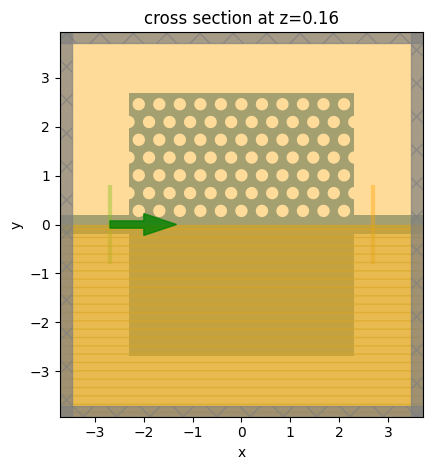

In [9]:
sim_te.plot(z=t / 2);

To further investigate the grids, we overlay the grid on top of the structures and zoom in on a small area. The grid looks sufficiently fine.

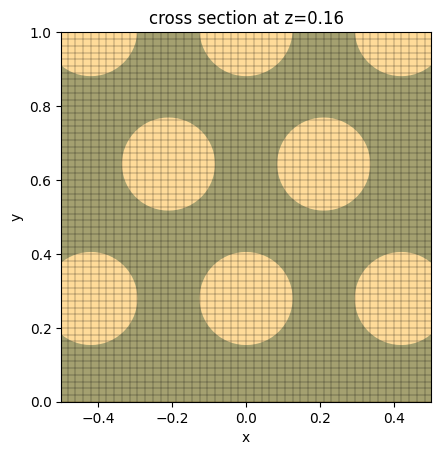

In [10]:
fig, ax = plt.subplots()
sim_te.plot(z=t / 2, ax=ax)
sim_te.plot_grid(z=t / 2, ax=ax)
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(0, 1);

Lastly, we use the [ModeSolver](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.plugins.ModeSolver.html) plugin to visualize the mode profile launched by the mode source. The mode field confirms that we are launching the fundamental TE mode at the input waveguide. 

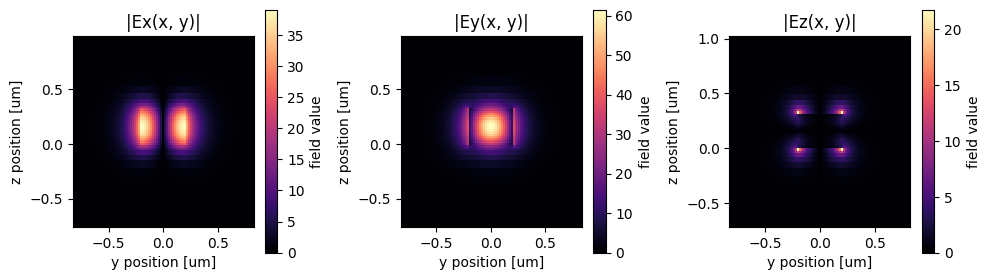

In [11]:
# define mode solver
mode_solver = ModeSolver(
    simulation=sim_te,
    plane=td.Box(center=mode_source.center, size=mode_source.size),
    mode_spec=mode_spec,
    freqs=[freq0],
)
mode_data = mode_solver.solve()

# visualize mode fields
f, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(10, 3))
abs(mode_data.Ex.isel(mode_index=0)).plot(x="y", y="z", ax=ax1, cmap="magma")
abs(mode_data.Ey.isel(mode_index=0)).plot(x="y", y="z", ax=ax2, cmap="magma")
abs(mode_data.Ez.isel(mode_index=0)).plot(x="y", y="z", ax=ax3, cmap="magma")

ax1.set_title("|Ex(x, y)|")
ax1.set_aspect("equal")
ax2.set_title("|Ey(x, y)|")
ax2.set_aspect("equal")
ax3.set_title("|Ez(x, y)|")
ax3.set_aspect("equal")
plt.show()

The TM incidence simulation can be made simply by copying the TE simulation while updating the symmetry condition to `(0,1,0)`. Then a simulation batch consisting of both simulations is defined. This way, both simulations will be running in parallel on the server, which will substantially save the total simulation time. 

In [12]:
# copy the te simulation to make the tm simulation
sim_tm = sim_te.copy(
    update={"symmetry": (0, 1, 0)}
)  

# define simulation batch
sims = {"TE": sim_te, "TM": sim_tm}

Submit the simulation batch to the server.

In [13]:
batch = web.Batch(simulations=sims)
batch_results = batch.run(path_dir="data")

[08:50:33] INFO     Using Tidy3D credentials from stored file.                                           ]8;id=196897;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\auth.py\auth.py]8;;\:]8;id=815911;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\auth.py#70\70]8;;\

[08:50:34] INFO     Authentication successful.                                                           ]8;id=914110;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\auth.py\auth.py]8;;\:]8;id=56790;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\auth.py#30\30]8;;\

[08:50:35] INFO     Created task 'TE' with task_id '7550a776-9b32-400c-b0ab-ffb72ff9a3df'.            ]8;id=980754;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=49890;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#120\120]8;;\

Output()

[08:50:36] INFO     Auto meshing using wavelength 1.5500 defined from sources.                     ]8;id=280254;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\components\grid\grid_spec.py\grid_spec.py]8;;\:]8;id=907625;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\components\grid\grid_spec.py#510\510]8;;\

           INFO     Created task 'TM' with task_id '55436fa7-f556-4f05-a951-d3e2cce72e30'.            ]8;id=149067;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=579335;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#120\120]8;;\

Output()

[08:50:41] Started working on Batch.                                                               ]8;id=702565;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\container.py\container.py]8;;\:]8;id=446685;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\container.py#361\361]8;;\

Output()

[09:03:01] Batch complete.                                                                         ]8;id=504935;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\container.py\container.py]8;;\:]8;id=627518;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\container.py#382\382]8;;\

## Postprocessing and Result Visualization 

After the batch of simulations is complete, we first visualize the field intensity distributions in both cases. As expected, the TE mode is blocked and the TM mode transmits through the photonic crystal region. 

[09:03:01] INFO     downloading file "output/monitor_data.hdf5" to                                    ]8;id=356425;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=686085;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#592\592]8;;\
                    "data\7550a776-9b32-400c-b0ab-ffb72ff9a3df.hdf5"                                               

Output()

[09:03:03] INFO     loading SimulationData from data\7550a776-9b32-400c-b0ab-ffb72ff9a3df.hdf5        ]8;id=718341;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=752288;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#414\414]8;;\

           INFO     downloading file "output/monitor_data.hdf5" to                                    ]8;id=828771;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=444340;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#592\592]8;;\
                    "data\55436fa7-f556-4f05-a951-d3e2cce72e30.hdf5"                                               

Output()

[09:03:04] INFO     loading SimulationData from data\55436fa7-f556-4f05-a951-d3e2cce72e30.hdf5        ]8;id=99792;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=490998;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#414\414]8;;\

[09:03:05] INFO     Auto meshing using wavelength 1.5500 defined from sources.                     ]8;id=432835;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\components\grid\grid_spec.py\grid_spec.py]8;;\:]8;id=359231;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\components\grid\grid_spec.py#510\510]8;;\

           INFO     Auto meshing using wavelength 1.5500 defined from sources.                     ]8;id=425221;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\components\grid\grid_spec.py\grid_spec.py]8;;\:]8;id=784028;file://C:\Users\xinzhong\anaconda3\envs\tidy3d_env\lib\site-packages\tidy3d\components\grid\grid_spec.py#510\510]8;;\

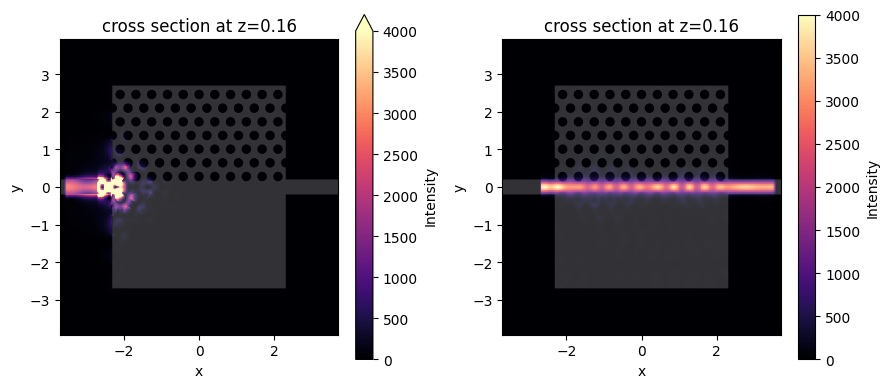

In [14]:
# get individual simulation data from batch result
sim_data_te = batch_results["TE"]
sim_data_tm = batch_results["TM"]

# plot the field intensities in the te and tm cases
fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(9, 4))
sim_data_te.plot_field("field", "int", ax=ax1, vmin=0, vmax=4000)
sim_data_tm.plot_field("field", "int", ax=ax2, vmin=0, vmax=4000);

To quantify the filter performance, we plot the transmission in both simulations. The result shows a good transmission (about -0.5 dB) for the TM mode and a low transmission (about -40 dB) for the TE mode. That is, the designed filter functions well while being very compact in size. 

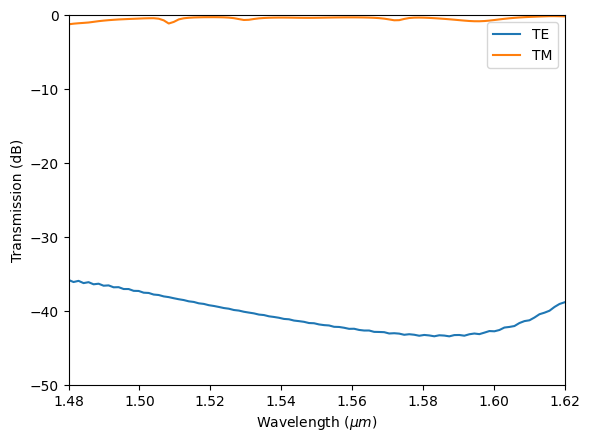

In [15]:
T_te = sim_data_te["flux"].flux
T_tm = sim_data_tm["flux"].flux

# plot the transmissions in the te and tm cases
plt.plot(ldas, 10 * np.log10(T_te), label="TE")
plt.plot(ldas, 10 * np.log10(T_tm), label="TM")
plt.xlim(1.48, 1.62)
plt.ylim(-50, 0)
plt.xlabel("Wavelength ($\mu m$)")
plt.ylabel("Transmission (dB)")
plt.legend();